In [1]:
from collections import Sequence
from scipy import constants

from scipy.optimize import approx_fprime

import numpy as np
import matplotlib.pyplot as plt

from pescado.mesher import patterns
from pescado.mesher import shapes
from pescado.poisson import Problem, ProblemBuilder
from pescado.tools import SparseVector

import ildos
import solver
import problem

/tmp/ipykernel_368978/862455406.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Sequence


In [2]:
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size=30)

In [3]:
def disc_ildos(surf):

    dos = 1 * (0.067 * constants.m_e) / (np.pi * constants.hbar ** 2)
    dens_helm = dos * 1e-18 * constants.elementary_charge * surf
    # The value of A corresponds to a one-dimension unit cell

    coord = np.empty((3, 2), dtype=float)
    coord[:, 0] = np.array([-1, 0, 1])
    coord[:, 1] = np.array([0, 0, dens_helm])

    return coord


In [4]:
def ildos_pesca(mu):

#    const = (10
#             * ((2 * 0.067 * constants.m_e * 1e-18) / constants.hbar ** 2) ** (3/2)
#             * (2 / 3)
#             * (1 / (2 * np.pi ** 2)))
    aq = 1e-9
    t = constants.hbar**2 / (2. * constants.m_e * 0.067 * aq**2)
    dens = (1 / t ** 2) * (1 / (2 * np.pi)) * 2 * (constants.elementary_charge ** 2)
   
    if not isinstance(mu, (np.ndarray, Sequence)):
        if mu <= 0:
            dens_ =  0
            ildos_ =  0
        else:
            dens_ = 2 * dens * mu
            ildos_ = dens * (mu ** 2)
    else:
        mu_zero = mu <= 0
        ildos_ = dens * (mu ** 2)
        ildos_[mu_zero] = 0
        dens_ = 2 * np.ones(len(mu)) * dens * mu
        
    return dens_, ildos_

def ildos_zero(mu):
    if not isinstance(mu, (np.ndarray, Sequence)):
        return 0, 0
    else:
        return np.zeros(len(mu)), np.zeros(len(mu))

coord = np.empty((3, 2), dtype=float)
coord[:, 0] = np.array([-1, 0, 1])
coord[:, 1] = np.array([0, 0, ildos_pesca(1)[1]])

ildos_cont = ildos.PContinuousIldos(coordinates=coord, functions=[ildos_zero, ildos_pesca])

In [5]:
dos = 1 * (0.067 * constants.m_e) / (np.pi * constants.hbar ** 2)
dens_helm = dos * 1e-18 * constants.elementary_charge * 2 * 2
print(dens_helm)

1.1195203402076617


In [6]:
# Define the ProblemBuilder
pb = ProblemBuilder()

### Define the Finite volume mesh
# Begin defining the mesh spacing
rect_pattern = patterns.Rectangular.constant(element_size=(4, 10))
# Define the space occupied by the system
system = shapes.Box(lower_left=[-1000, -55], size=[2000, 600])

# Make the mesh
pb.initialize_mesh(
  simulation_region=system, pattern=rect_pattern)

### Set relative dielectric permittivity
dielectric = shapes.Box(lower_left=[-1000, -55], size=[2e3, 160])
pb.set_relative_permittivity(val=12, region=dielectric)

gate = (shapes.Box(lower_left=[-1000, 105], size=[650, 10])
        | shapes.Box(lower_left=[-100, 105], size=[200, 10])
        | shapes.Box(lower_left=[350, 105], size=[650, 10]))
pb.set_relative_permittivity(val=1e4, region=gate)
                             
### Split sites into N, D, H and F.
# Define the remaining regions
dopants = shapes.Box(lower_left=[-1000, 35], size=[2000, 20])
twodeg = shapes.Box(lower_left=[-1000, -4.9], size=[2000, 9.8])

# Define local boundary conditions
pb.set_dirichlet(region=gate, setup_tag='gate')
pb.set_flexible(region=twodeg, setup_tag='2deg')
#pb.set_helmholtz(region=twodeg, setup_tag='2deg')
pb.set_neumann(region=dopants, setup_tag='dopants')

pd = pb.finalized()

In [7]:
sc_solver = solver.SchrodingerPoisson(ildos=ildos_cont, poisson_problem=pd)

sc_solver_A = solver.DiscretizedNR(ildos=ildos_cont, poisson_problem=pd)

In [8]:
poisson_input = {
    'voltage':pd.sparse_vector(val=-0.2, name='gate'), 
    'charge_density':pd.sparse_vector(val=1e23 * 1e-27, name='dopants')}

res = sc_solver.solve_discretized(
    poisson_input=poisson_input, 
    initial_guess=SparseVector(indices=pd.points(name='2deg'), 
                               values=np.zeros(len(pd.points(name='2deg')))))

res2 = sc_solver_A.solve(
    poisson_input=poisson_input, 
    initial_guess=SparseVector(indices=pd.points(name='2deg'), 
                               values=np.zeros(len(pd.points(name='2deg')))))

Total time in solve 0.46764039993286133
Time spent solving the linear problem 0.36049747467041016
Total time in solve 0.39699649810791016
Time spent solving the linear problem 0.29212164878845215
Total time in solve 0.39976048469543457
Time spent solving the linear problem 0.29239559173583984
Total time in solve 0.40129733085632324
Time spent solving the linear problem 0.2940380573272705
Total time in solve 0.4035184383392334
Time spent solving the linear problem 0.291658878326416
Total time in solve 0.4054276943206787
Time spent solving the linear problem 0.2924034595489502
Total time in solve 0.39972686767578125
Time spent solving the linear problem 0.2920372486114502
Total time in solve 0.396806001663208
Time spent solving the linear problem 0.2897989749908447
Total time in solve 0.3953733444213867
Time spent solving the linear problem 0.29146265983581543
Total time in solve 0.3954493999481201
Time spent solving the linear problem 0.2908027172088623
Total time in solve 0.40634655952

In [9]:
res_pi = sc_solver.solve_plinear(
    poisson_input=poisson_input, 
    initial_fpoints=np.array([-.5, .0, .5, .9]), 
    initial_guess=SparseVector(indices=pd.points(name='2deg'), 
                               values=np.zeros(len(pd.points(name='2deg')))),
    max_ite=5)

At solve discretized
Total time in solve 0.46823716163635254
Time spent solving the linear problem 0.3649108409881592
Total time in solve 0.39133358001708984
Time spent solving the linear problem 0.2892923355102539
0
Total time in solve 0.4901731014251709
Time spent solving the linear problem 0.37717342376708984
Total time in solve 0.3959953784942627
Time spent solving the linear problem 0.2908031940460205


In [10]:
print(ildos_pesca(0.5))
print(ildos_pesca(0.5))


(0.9843597752843698, 0.24608994382109245)
(0.9843597752843698, 0.24608994382109245)


In [11]:

isinstance(list(), Sequence)

True

In [12]:
ildos_pesca(0.01)

(0.019687195505687396, 9.843597752843698e-05)

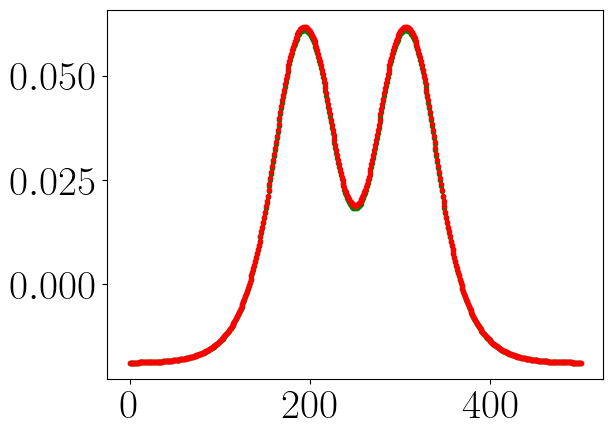

In [13]:
plt.plot(
    res['iteration_data'][-1]['quantum_potential'].values, 'g.')

plt.plot(
    res['iteration_data'][-5]['quantum_potential'].values, 'r.')


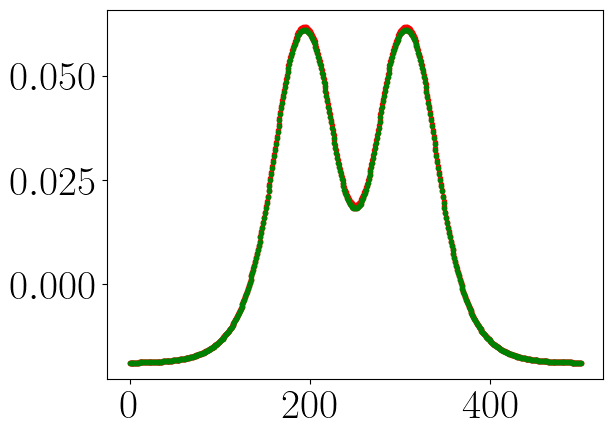

In [14]:
plt.plot(
    res['iteration_data'][-1]['quantum_total_charge'].values, 'g.')

plt.plot(
    ildos_pesca(
        res['iteration_data'][-1]['quantum_potential'].values)[1], 'r.')

#plt.plot(
#    res_pi['iteration_data'][-1]['iteration_data'][-1]['quantum_total_charge'].values, 'r.')
plt.show()
plt.plot(
    res['iteration_data'][-1]['quantum_potential'].values, 'r.')

plt.plot(
    res['iteration_data'][-5]['quantum_potential'].values, 'r.')

plt.plot(
    res['iteration_data'][-1]['chem'].values, 'g.')

#plt.plot(
#    res['iteration_data'][-1]['quantum_potential'].values, 'r.')

#plt.ylim([-.002, 0])
#plt.plot(
#    res['iteration_data'][-2]['quantum_potential'].values, 'g.')


#plt.plot(
#    res_pi['iteration_data'][-1]['iteration_data'][-1]['quantum_potential'].values, 'r.')

In [15]:
old_sc_solver = problem.SchrodingerPoisson(
    ildos=disc_ildos(surf=2), poisson_problem_inst=pd)

In [16]:
initial_config = pd.sparse_vector(
    val=1, indices=pd.points(name='2deg'), dtype=int)

old_sc_solver.initialize(
    initial_guess=initial_config,
    poisson_problem_input=poisson_input,
    return_poisson_output=False)

old_sc_solver.iterate()

while np.any(
        np.abs(old_sc_solver.iteration_data[-1]['interval']
                - old_sc_solver.iteration_data[-2]['interval']) != 0):

    old_sc_solver.iterate()

gas_charge = old_sc_solver.charge(iteration=-1)
gas_voltage = old_sc_solver.potential(iteration=-1)

Total time in solve 0.40521883964538574
Time spent solving the linear problem 0.297771692276001
Total time in solve 0.3975186347961426
Time spent solving the linear problem 0.2929072380065918
Total time in solve 0.39452505111694336
Time spent solving the linear problem 0.29143476486206055
Total time in solve 0.41156506538391113
Time spent solving the linear problem 0.3026001453399658
Total time in solve 0.394317626953125
Time spent solving the linear problem 0.2892622947692871


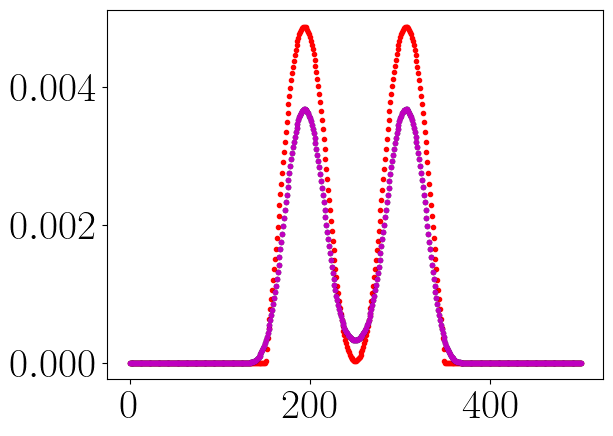

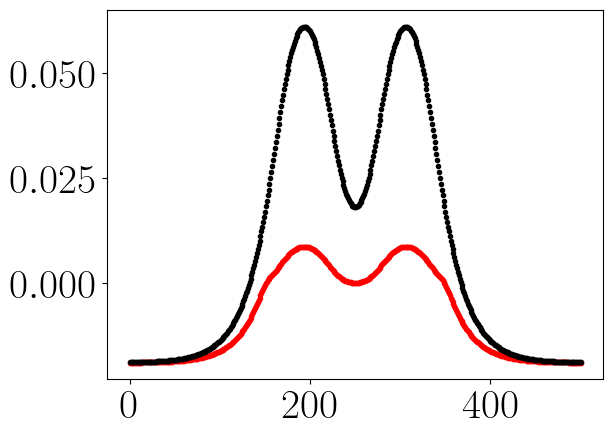

In [22]:
cov_pot = res['iteration_data'][-1]['quantum_potential'].values

plt.plot(gas_charge.values, 'r.')

plt.plot(
    res['iteration_data'][-1]['quantum_total_charge'].values, 'k.')

plt.plot(ildos_cont(cov_pot)[1], 'm.')

#plt.plot(
#    ildos_cont(res_pi['iteration_data'][-1]['iteration_data'][-1]['quantum_potential'].values)[1], 
#    'm')

plt.show()

plt.plot(gas_voltage.values, 'r.')

plt.plot(res['iteration_data'][-1]['quantum_potential'].values, 'k.')

#plt.plot(res_pi['iteration_data'][-1]['iteration_data'][-1]['quantum_potential'].values, 'm.')

#plt.plot(cov_pot, 'g.')



In [ ]:
res_pi['iteration_fpoints'][-1]

In [ ]:
ildos_cont(u=cov_pot)

In [ ]:
res['iteration_data'][-2]['quantum_potential'].values[
    res['iteration_data'][-2]['quantum_potential'].values > 0]